In [86]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D

In [2]:
OUTPUT_DATA = False

In [3]:
scriptDir = os.getcwd() # Assumes that script is executed from its actual location
relPath = r"../data/" # And data is located in a 'data' folder in the same parent directory as 'code' folder
trainFilePath = os.path.join(scriptDir, relPath,"train.csv")
valFilePath = os.path.join(scriptDir, relPath,"validation.csv")
sampleFilePath = os.path.join(scriptDir, relPath,"sample.csv")
relPathOutput = r"../output/"
outputFolderPath = os.path.join(scriptDir, relPathOutput)

In [65]:
# Load data
df = pd.read_csv(trainFilePath, sep=',',header=0, quotechar='"')

In [66]:
# get min floorprice and max payprice to use as the range of constant bids we will try
minBid = df['slotprice'].min()
maxBid = df['payprice'].max()

In [67]:
def evalRandomBid(df, low, high, budget=6250*1000, repeat=5):
    # generate series of bids within the provided bounds
    bidValues = pd.Series(np.random.randint(low, high, (df.shape[0],)))
    # remove everything we wouldn't win, we don't care about it anymore
    dfWon = df[['bidid', 'payprice', 'click']][df['payprice'] <= bidValues].copy()

    results = np.zeros((repeat, 6))
    for iteration in range(repeat):
        # now evaluate sequentially to see what the results are
        # first random sample (taking everything without replacement equivalent to a shuffle)
        # although if only do 1 test, then don't bother
        if repeat > 1:
            dfWon = dfWon.sample(frac=1)
        # now create cumulative spend
        dfWon['cumSpend'] = dfWon['payprice'].cumsum()
        dfWon['cumSpendLead'] = dfWon['cumSpend'].shift(1, fill_value=0)
        dfRes = dfWon[dfWon['cumSpendLead'] <= budget]
        # and get stats
        numClicks = dfRes['click'].sum()
        numImps = dfRes['bidid'].count()
        totalCPM = dfRes['payprice'].sum()
        spend = totalCPM / 1000

        if numImps > 0:
            CTR = numClicks / numImps
            aveCPM = totalCPM / numImps
        else:
            CTR = np.NaN
            aveCPM = np.NaN

        if numClicks > 0:
            aveCPC = spend / numClicks
        else:
            aveCPC = np.NaN
        
        results[iteration,:] = np.array([numImps, numClicks, CTR, spend, aveCPM, aveCPC])
        
    resultsMean = np.mean(results, axis=0)
        
    return resultsMean

In [68]:
results = list()
for lowerLimit in range(minBid, maxBid+1, 10):
    for upperLimit in range(maxBid, minBid-1, -10):
        if lowerLimit>=upperLimit:
            continue
        stats = evalRandomBid(df, lowerLimit, upperLimit, repeat=1)
        results.append(np.hstack(([lowerLimit, upperLimit], stats)))
results = np.array(results)

In [69]:
optMin, optMax = results[np.argmax(results[:,2]), 0:2]
optMin, optMax #show

(20.0, 30.0)

In [70]:
results[np.argmax(results[:,2]), :]

array([2.00000000e+01, 3.00000000e+01, 4.09975000e+05, 1.33000000e+02,
       3.24410025e-04, 6.25000600e+03, 1.52448466e+01, 4.69925263e+01])

In [77]:
# try again with a more restricted range (the best values from the full run)
minBid = optMin
maxBid = optMax
resultsRestr = list()
for lowerLimit in range(minBid, maxBid+1, 1): # now increment by 1
    for upperLimit in range(maxBid, minBid-1, -1):
        if lowerLimit>=upperLimit:
            continue
        stats = evalRandomBid(df, lowerLimit, upperLimit, repeat=1)
        resultsRestr.append(np.hstack(([lowerLimit, upperLimit], stats)))
resultsRestr = np.array(resultsRestr)

In [78]:
optMin, optMax = resultsRestr[np.argmax(resultsRestr[:,2]), 0:2]
optMin, optMax #show
# It's very very close to the constant bid result

(21.0, 24.0)

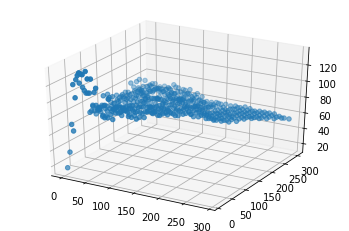

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0], results[:,1], results[:,3]);
# TODO label axes

In [81]:
# Now let's look at the validation set
valDf = pd.read_csv(valFilePath, sep=',',header=0, quotechar='"')

In [83]:
minBid = valDf['slotprice'].min()
maxBid = valDf['payprice'].max()
# full run
resultsVal = list()
for lowerLimit in range(minBid, maxBid+1, 10):
    for upperLimit in range(maxBid, minBid-1, -10):
        if lowerLimit>=upperLimit:
            continue
        stats = evalRandomBid(valDf, lowerLimit, upperLimit, repeat=1)
        resultsVal.append(np.hstack(([lowerLimit, upperLimit], stats)))
resultsVal = np.array(resultsVal)
optMinVal, optMaxVal = resultsVal[np.argmax(resultsVal[:,2]), 0:2]
optMinVal, optMaxVal #show

(60.0, 80.0)

In [85]:
# try again with a more restricted range (the best values from the full run)
minBid = int(optMinVal)
maxBid = int(optMaxVal)
resultsValRestr = list()
for lowerLimit in range(minBid, maxBid+1, 1): # now increment by 1
    for upperLimit in range(maxBid, minBid-1, -1):
        if lowerLimit>=upperLimit:
            continue
        stats = evalRandomBid(valDf, lowerLimit, upperLimit, repeat=1)
        resultsValRestr.append(np.hstack(([lowerLimit, upperLimit], stats)))
resultsValRestr = np.array(resultsValRestr)
optMinVal, optMaxVal = resultsValRestr[np.argmax(resultsValRestr[:,2]), 0:2]
optMinVal, optMaxVal #show

(66.0, 76.0)

In [91]:
# Not quite the same as the constant bid result (82) but maybe just due to random nature, ideally would run multiple times.

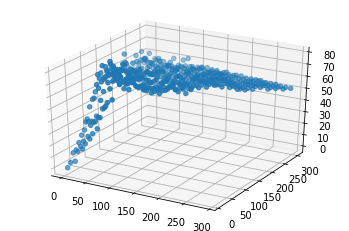

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(resultsVal[:,0], resultsVal[:,1], resultsVal[:,3]);
# TODO label axes